## This notebook will provide you with an introduction to the repository and assist you in getting your data set up

### 1. tensor_hero module

I highly recommend parsing through each file in the tensor_hero module and reading through the functions and their docstrings.

The tensor_hero module is defined in the tensor_hero folder. It contains a suite of useful functions which you can import easily. Here's how that might work:

    from tensor_hero.preprocessing.data import populate_processed_folder

    <do something with populate_processed_folder>

If you wanted to see how populated_processed_folder() works, just navigate to
> ./tensor_hero/preprocessing/data.py

then read the docstring about populate_processed_folder()

Writing the line above will work in this jupyter notebook because its working directory contains the tensor_hero module, i.e. the folder structure is

tensor-hero *(this is the working directory)*\
-> tensor_hero *(this is the module)* \
-> \<other folders and scripts\> \
-> initialization.ipynb *(the script is not in the same directory as the module)*

If you wanted to use the tensor hero module in a directory other than the repo's home directory, you'll need to add the repo's home directory to the system's path explicitly. Let's say the folder structure was


tensor-hero \
-> tensor_hero *(this is the module)* \
-> \<other folders and scripts\> \
-> some_other_folder *(this is the working directory)*\
-----> initialization.ipynb *(the script is not in the same directory as the module)*

Now the working directory doesn't contain the tensor_hero module, so you need to add the top-level directory to your system path. This would look something like this:

    from pathlib import Path
    import sys
    sys.path.insert(1, str(Path.cwd().parent))
    from tensor_hero.visualization import slice_notes, plot_chart

or, in pseudocode

    import pathlib library, which makes it easy to work with filepaths
    import sys, which will be used to append to the system path
    append the directory outside of this one (Path.cwd().parent) to the system path
    import tensor_hero functions

If this was a .py file rather than .ipynb, we would need to append the current working directory to the path:

    from pathlib import Path
    import sys
    sys.path.insert(1, str(Path.cwd()))
    from tensor_hero.visualization import slice_notes, plot_chart

Please be sure to use the pathlib library rather than hardcoding your own computer's filepath when doing these import statements

Now, let's see some of the things you can do with this module

#### Visualize the audio and notes of a song

In [1]:
# First, we load a song

from pathlib import Path
import os
from tensor_hero.visualization import plot_chart, slice_notes # some visualization functions

song_dir = Path.cwd() / 'example_song'  # This example directory is good for experimenting with dummy data

print('Here are the files in the song directory:')
print(os.listdir(song_dir))

Here are the files in the song directory:
['album.png', 'generated', 'notes.chart', 'notes.npy', 'notes_simplified.npy', 'separated.ogg', 'song.ini', 'song.ogg', 'spectrogram.npy']


- album.png -> album art
- notes.chart -> raw chart file
- notes.npy -> notes array
- notes_simplified.npy -> simplified notes array
- separated.ogg -> source separated audio file
- song.ini -> song metadata for Clone Hero use
- song.ogg -> raw audio file
- spectrogram.npy -> spectrogram from raw audio file

In [ ]:
# Let's print a few lines of the .chart file to see which song we're dealing with

with open(song_dir / 'notes.chart', 'r', encoding="utf-8") as f:
    for idx, line in enumerate(f.readlines()):
        print(line)
        if idx > 5:
            break

Spectrogram and notes have the same length in the time dimension:
spectrogram shape: (512, 13931)
notes shape: (13931,)


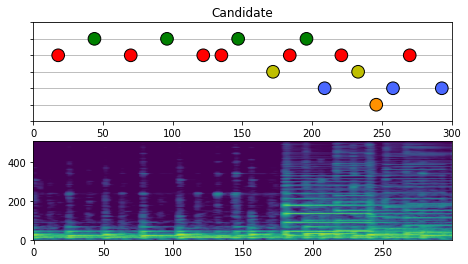

In [2]:
import numpy as np

# Okay it looks like we're going to be investigating the song Ouray.
# Let's plot a subsection of it's notes

# Load the spectrogram and notes
spec = np.load(song_dir / 'spectrogram.npy')        # Recall, spectrograms are 2D numpy arrays detailing frequency over time
notes = np.load(song_dir / 'notes_simplified.npy')  # Notes arrays detail notes present at every time bin in the song

print('Spectrogram and notes have the same length in the time dimension:')
print(f'spectrogram shape: {spec.shape}')
print(f'notes shape: {notes.shape}')

# plot_chart() is useful for plotting spectrograms and printing guitar hero notes
# slice_notes() cuts the notes or audio between a specified start and end point in seconds
_ = plot_chart(candidate=slice_notes(notes, 5, 8), audio=slice_notes(spec, 5, 8))


slice_notes() can be used on both notes arrays and audio.

What is the notes array though? Let's check it out.

In [ ]:
notes_section = slice_notes(notes, 5, 8)  # The notes array between seconds 5 and 8 of the song
print('raw notes array encompassing 3 seconds of song data:')
print(notes_section)

print('\nLet\'s highlight just the ticks with notes, only for the first 1 second of song data.')
print('tick : note')
for i, x in enumerate(list(notes_section)):
    if i > 100:
        break
    if x:
        print(f'{i} : {int(x)}')
        
print('\nYou could read this as: \nred note at 180ms \ngreen note at 440ms \nred note at 700ms \ngreen note at 960ms')
_ = plot_chart(candidate=notes_section)

### 2. Machine Learning

When we give our data as input to the machine learning model, we have to transform it in a way that the model can understand. We follow the heuristic of Hawthorne et al. in Sequence-to-Sequence Piano Transcription with transformers

We represent each note as two separate pieces of information: a time step and a note. When comparing output, the model sees the time step, then it sees the note corresponding to that time step. This might seem counterintuitive, but the transformer model actually does a really good job of learning to output time steps then note selections in sequential order.

A ground truth vector might looks something like this:

    [432, 36, 4, 89, 0, 433, 434, 434, 434]

which can be translated as

    [<start of sequence>, <40ms from start>, <orange note>, <570ms from start>, <green note>, <end of sequence>, <pad>, <pad>, <pad>]

See tensor-hero/Documentation/'format of model 1 data.txt' for more information.

Each spectrogram input is limited to 400 frames, or 4 seconds of audio data and time bins are predicted relative to the start of that audio segment. During inference, songs are chopped into 4 second chunks, predicted, then concatenated.

As an exercise, let's convert some portion of a notes array to this format:

In [ ]:
from tensor_hero.preprocessing.model import __notes_to_output_space, __prepare_notes_tensor

print('Original notes array:')
print(notes_section)

# We convert the notes arrays in a sequence of two functions
# Note that the prepended double underscore typically means "for internal use" i.e. these
# are functions that are not usually imported
prepared_notes = __notes_to_output_space(notes_section)
prepared_notes = __prepare_notes_tensor(prepared_notes)

print('\nReformatted notes:')
print(prepared_notes)

Generally, we add the padding during the dataloading process

Now, let's check out the model inference process. We'll use a (super dumb) model we've already trained. These saved models can be found in
>tensor-hero/model/'saved models'

In [ ]:
import pickle
import json

# First, let's load the model's parameters and define a Transformer model with them
# Let's take a look at these parameters, they're stored in a dictionary

model_path = Path.cwd() / 'model' / 'saved models' / 'model12'
with open(model_path / 'params.pkl', 'rb') as f:
    params = pickle.load(f)
    
print(json.dumps(params, indent=4))

In [ ]:
from tensor_hero.model import Transformer
import torch

# We use these parameters to define the skeleton of the model, then load the weights into it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device = {device}')

# Model hyperparameters are derived from the params dictionary
trg_vocab_size = params['trg_vocab_size']
embedding_size = params['embedding_size']
num_heads = params['num_heads']
num_encoder_layers = params['num_encoder_layers']
num_decoder_layers = params['num_decoder_layers']
dropout = params['dropout']
max_len = params['max_trg_len']
forward_expansion = params['embedding_size']*params['forward_expansion']

model = Transformer(
    embedding_size,
    trg_vocab_size,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device)  # Always send the model to the GPU

# Load the weights into the model
model.load_state_dict(torch.load(model_path / 'model12.pt'))

print(model)

Cool! Looks like we're ready to do inference. We're going to send the model's output to
>tensor-hero/example_song/generated

In [ ]:
from tensor_hero.inference import full_song_prediction

# Define the folder to hold the output of the model
outfolder = Path.cwd() / 'example_song' / 'generated'
audio_file = song_dir / 'song.ogg'

# We have to define some things for the .chart file so it's actually playable
# just some dummy metadata for now
song_metadata = {'Name' : 'model12',
                'Artist' : 'Forrest',       # Forrest is the honorary author of all of our output
                'Charter' : 'tensorhero',
                'Offset' : 0,
                'Resolution' : 192,
                'Genre' : 'electronic',
                'MediaType' : 'cd',
                'MusicStream' : 'song.ogg'}

_ = full_song_prediction(song_path = audio_file,
                         model=model,
                         device=device,
                         sos_idx=432,
                         max_len=500,
                         song_metadata=song_metadata,
                         outfolder=outfolder)

### 3. Setting up training data

Importantly, the programs in this repo assume a particular directory structure for the  training data. This is how it should be initialized:

Training Data \
-> Unprocessed \
-> Processed

**Place 'Training Data' in the same directory as this repository.** Make sure you add it to the .gitignore if it isn't already there so you don't accidentally upload all the training data to GitHub. 

The directories should be empty at this point. To populate them, navigate to this link, https://docs.google.com/spreadsheets/d/13B823ukxdVMocowo1s5XnT3tzciOfruhUVePENKc01o/edit#gid=0 , and download the following track packs:
- Angevil Hero II
- Anti Hero
- Anti Hero 2
- Community Track Pack 6
- Digitizer
- Facelift Pack 1
- Facelift Pack 2
- Focal Point
- Guitar Hero X
- Paradigm

The track packs should be unzipped into the Unprocessed folder
> Training Data/Unprocessed

Once the track packs are unzipped, **run the cell at the end of this notebook to populate the processed folder, this might take a while.**

Before then, take some time to check out this introduction.


## Run this cell after the track packs are downloaded and unzipped to preprocess the training data

In [ ]:
# To process the training data, we will use the populated_processed_folder()
from pathlib import Path
import os
from tensor_hero.preprocessing.data import populate_processed_folder, populate_with_simplified_notes

unprocessed_path = Path.cwd() / 'Training Data' / 'Unprocessed'
processed_path = Path.cwd() / 'Training Data' / 'Processed'

assert (os.path.isdir(unprocessed_path) and os.path.isdir(processed_path)), 'ERROR: Place "Training Data" folder in this directory'

processing_data = populate_processed_folder(unprocessed_data_path=unprocessed_path,
                                            processed_data_path=processed_path)


After the initial processing, we need to simplify the notes arrays into our current format

In [ ]:
populate_with_simplified_notes(processed_path)

### 4. Misc useful functions

Get a list of all the .ogg files in the training data

(You have to have the training data set up before this works)

In [ ]:
from tensor_hero.preprocessing.data import get_list_of_ogg_files

# ogg_file_paths contains unprocessed paths to ogg files, processed_paths contains their processed
# analogs.
ogg_file_paths, processed_paths = get_list_of_ogg_files(unprocessed_path)

Compute the spectrogram of some audio

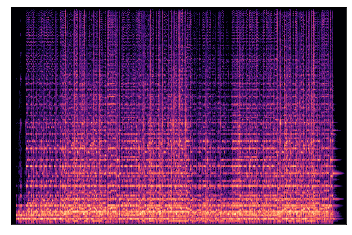

In [3]:
from librosa.display import specshow
from tensor_hero.preprocessing.audio import compute_mel_spectrogram

audio_file = song_dir / 'song.ogg'
spec = compute_mel_spectrogram(audio_file)

specshow(spec)